# IND320 — Project Part 4  
### Elhub Data Processing, Analysis, and Streamlit Application

This notebook contains the main steps of my work in Part 4 of the project.  
It documents how I collected hourly production and consumption data from the Elhub API, cleaned and combined the datasets for 2021–2024, and stored them in both MongoDB and Cassandra.  
The notebook also includes checks of the loaded data, basic summaries, screenshots from the Streamlit app, and a short log describing the development process and challenges I worked through.  
All code cells are commented so the workflow can be followed and reproduced easily.


In [8]:
# !pip install python-dotenv pymongo dnspython pyspark plotly requests
# Spark Cassandra connector is provided via spark.jars.packages in the SparkSession builder.

from datetime import datetime, timedelta
from typing import List, Dict, Tuple
import time, os, json
import requests
import pandas as pd
from zoneinfo import ZoneInfo
from dotenv import load_dotenv, find_dotenv

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *


## 1) Config (Elhub + global)

In [9]:
# Elhub API
ELHUB_BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
DATASET_PROD = "PRODUCTION_PER_GROUP_MBA_HOUR"
DATASET_CONS = "CONSUMPTION_PER_GROUP_MBA_HOUR"

UTC = ZoneInfo("UTC")
PAUSE_S = 0.4
TIMEOUT_S = 30

# Ranges
PROD_YEARS = [2022, 2023, 2024]        # append after your 2021 data (already done in Part 2)
CONS_YEARS = [2021, 2022, 2023, 2024]  # new dataset

# Utility: build monthly (start, end) UTC windows for a given year
def monthly_windows(year: int) -> List[Tuple[datetime, datetime]]:
    wins = []
    for m in range(1, 13):
        start = datetime(year, m, 1, 0, 0, 0, tzinfo=UTC)
        next_year = year + (m // 12)
        next_month = (m % 12) + 1
        end = datetime(next_year, next_month, 1, 0, 0, 0, tzinfo=UTC)
        wins.append((start, end))
    return wins


## 2) Fetch helper

In [10]:
session = requests.Session()

def fetch_elhub(dataset: str, start_dt: datetime, end_dt: datetime) -> List[Dict]:
    """Fetch one monthly window from Elhub and return flattened hourly records list."""
    params = {
        "dataset": dataset,
        "startDate": start_dt.isoformat(),  # UTC (no DST issues)
        "endDate": end_dt.isoformat(),
    }
    try:
        r = session.get(ELHUB_BASE_URL, params=params, timeout=TIMEOUT_S)
        r.raise_for_status()
        payload = r.json()
    except requests.RequestException as e:
        print(f"{start_dt:%Y-%m} — omitted (I/O): {e}")
        return []

    out = []
    for area in payload.get("data", []):
        attrs = area.get("attributes") or {}
        # key is productionPerGroupMbaHour OR consumptionPerGroupMbaHour depending on dataset
        key = "productionPerGroupMbaHour" if "PRODUCTION" in dataset else "consumptionPerGroupMbaHour"
        chunk = attrs.get(key) or []
        if isinstance(chunk, list):
            out.extend(chunk)
    return out

def fetch_years(dataset: str, years: List[int]) -> pd.DataFrame:
    all_records = []
    print(f"Fetching {dataset} for years: {years}")
    for y in years:
        for (start_dt, end_dt) in monthly_windows(y):
            rows = fetch_elhub(dataset, start_dt, end_dt)
            all_records.extend(rows)
            time.sleep(PAUSE_S)
    if not all_records:
        print("No data retrieved.")
        return pd.DataFrame()
    df = pd.DataFrame(all_records)
    # Normalize times to UTC (keep tz-aware)
    for col in ("startTime", "endTime", "lastUpdatedTime"):
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")
    # Order columns
    preferred = ["startTime", "endTime", "lastUpdatedTime", "priceArea", "productionGroup", "quantityKwh"]
    ordered = [c for c in preferred if c in df.columns] + [c for c in df.columns if c not in preferred]
    df = df[ordered]
    print(f"Retrieved rows: {len(df):,}")
    return df


 ## 3) Fetch production (2022–2024) and consumption (2021–2024)

In [11]:
df_prod_22_24 = fetch_years(DATASET_PROD, PROD_YEARS)
df_cons_21_24 = fetch_years(DATASET_CONS, CONS_YEARS)

display(df_prod_22_24.head())
display(df_prod_22_24.shape)
display(df_cons_21_24.head())
display(df_cons_21_24.shape)


Fetching PRODUCTION_PER_GROUP_MBA_HOUR for years: [2022, 2023, 2024]
Retrieved rows: 657,600
Fetching CONSUMPTION_PER_GROUP_MBA_HOUR for years: [2021, 2022, 2023, 2024]
Retrieved rows: 876,600


,startTime,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh
0,2021-12-31 23:00:00+00:00,2022-01-01 00:00:00+00:00,2025-02-01 17:02:57+00:00,NO1,hydro,1291422.4
1,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+00:00,2025-02-01 17:02:57+00:00,NO1,hydro,1246209.4
2,2022-01-01 01:00:00+00:00,2022-01-01 02:00:00+00:00,2025-02-01 17:02:57+00:00,NO1,hydro,1271757.0
3,2022-01-01 02:00:00+00:00,2022-01-01 03:00:00+00:00,2025-02-01 17:02:57+00:00,NO1,hydro,1204251.8
4,2022-01-01 03:00:00+00:00,2022-01-01 04:00:00+00:00,2025-02-01 17:02:57+00:00,NO1,hydro,1202086.9


(657600, 6)

,startTime,endTime,lastUpdatedTime,priceArea,quantityKwh,consumptionGroup,meteringPointCount
0,2020-12-31 23:00:00+00:00,2021-01-01 00:00:00+00:00,2024-12-20 09:35:40+00:00,NO1,177071.56,cabin,100607
1,2021-01-01 00:00:00+00:00,2021-01-01 01:00:00+00:00,2024-12-20 09:35:40+00:00,NO1,171335.12,cabin,100607
2,2021-01-01 01:00:00+00:00,2021-01-01 02:00:00+00:00,2024-12-20 09:35:40+00:00,NO1,164912.02,cabin,100607
3,2021-01-01 02:00:00+00:00,2021-01-01 03:00:00+00:00,2024-12-20 09:35:40+00:00,NO1,160265.77,cabin,100607
4,2021-01-01 03:00:00+00:00,2021-01-01 04:00:00+00:00,2024-12-20 09:35:40+00:00,NO1,159828.69,cabin,100607


(876600, 7)

 ##  4) Start Spark & prepare DataFrames (snake_case)

In [12]:
# Ensure Python exe for executors
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (
    SparkSession.builder
    .appName("Elhub-Part4")
    .config("spark.cassandra.connection.host", "127.0.0.1")
    .config("spark.cassandra.connection.port", "9042")
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1")
    .getOrCreate()
)
print("Spark connected to Cassandra successfully.")

Spark connected to Cassandra successfully.


In [14]:
spark_df_prod_raw = spark.createDataFrame(df_prod_22_24)
spark_df_prod_raw.printSchema()
spark_df_prod_raw.show(5, truncate=False)

root
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- lastUpdatedTime: timestamp (nullable = true)
 |-- priceArea: string (nullable = true)
 |-- productionGroup: string (nullable = true)
 |-- quantityKwh: double (nullable = true)

+-------------------+-------------------+-------------------+---------+---------------+-----------+
|startTime          |endTime            |lastUpdatedTime    |priceArea|productionGroup|quantityKwh|
+-------------------+-------------------+-------------------+---------+---------------+-----------+
|2022-01-01 00:00:00|2022-01-01 01:00:00|2025-02-01 18:02:57|NO1      |hydro          |1291422.4  |
|2022-01-01 01:00:00|2022-01-01 02:00:00|2025-02-01 18:02:57|NO1      |hydro          |1246209.4  |
|2022-01-01 02:00:00|2022-01-01 03:00:00|2025-02-01 18:02:57|NO1      |hydro          |1271757.0  |
|2022-01-01 03:00:00|2022-01-01 04:00:00|2025-02-01 18:02:57|NO1      |hydro          |1204251.8  |
|2022-01-01 04:00:00|2022-0

In [15]:

spark_df_cons_raw = spark.createDataFrame(df_cons_21_24)
spark_df_cons_raw.printSchema()
spark_df_cons_raw.show(5, truncate=False)

root
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- lastUpdatedTime: timestamp (nullable = true)
 |-- priceArea: string (nullable = true)
 |-- quantityKwh: double (nullable = true)
 |-- consumptionGroup: string (nullable = true)
 |-- meteringPointCount: long (nullable = true)

+-------------------+-------------------+-------------------+---------+-----------+----------------+------------------+
|startTime          |endTime            |lastUpdatedTime    |priceArea|quantityKwh|consumptionGroup|meteringPointCount|
+-------------------+-------------------+-------------------+---------+-----------+----------------+------------------+
|2021-01-01 00:00:00|2021-01-01 01:00:00|2024-12-20 10:35:40|NO1      |177071.56  |cabin           |100607            |
|2021-01-01 01:00:00|2021-01-01 02:00:00|2024-12-20 10:35:40|NO1      |171335.12  |cabin           |100607            |
|2021-01-01 02:00:00|2021-01-01 03:00:00|2024-12-20 10:35:40|NO1      |164912.

### 4) Merging the columns into a single `energy_group` field


In [16]:
def normalize_columns(sdf):
    cols = set(sdf.columns)
    if "productionGroup" in cols:
        grp = F.col("productionGroup")
    elif "consumptionGroup" in cols:
        grp = F.col("consumptionGroup")
    else:
        raise ValueError(f"No group column found. Columns: {sorted(cols)}")
    last_upd = F.col("lastUpdatedTime") if "lastUpdatedTime" in cols else F.lit(None).cast("timestamp")
    return sdf.select(
        F.col("startTime").alias("start_time"),
        F.col("endTime").alias("end_time"),
        last_upd.alias("last_updated_time"),
        F.col("priceArea").alias("price_area"),
        grp.alias("energy_group"),
        F.col("quantityKwh").alias("value")
    )

sdf_prod_22_24 = normalize_columns(spark_df_prod_raw)
sdf_cons_21_24 = normalize_columns(spark_df_cons_raw)

sdf_prod_22_24.printSchema()
sdf_cons_21_24.printSchema()


root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- last_updated_time: timestamp (nullable = true)
 |-- price_area: string (nullable = true)
 |-- energy_group: string (nullable = true)
 |-- value: double (nullable = true)

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- last_updated_time: timestamp (nullable = true)
 |-- price_area: string (nullable = true)
 |-- energy_group: string (nullable = true)
 |-- value: double (nullable = true)



In [17]:
(
    sdf_prod_22_24.write.format("org.apache.spark.sql.cassandra").mode("append")
    .option("keyspace","energy_data").option("table","production_2022_2024").save()
)
(
    sdf_cons_21_24.write.format("org.apache.spark.sql.cassandra").mode("append")
    .option("keyspace","energy_data").option("table","consumption_2021_2024").save()
)


In [ ]:

### Quick Check
prod_chk = spark.read.format("org.apache.spark.sql.cassandra").options(
    keyspace="energy_data", table="production_2022_2024").load()
cons_chk = spark.read.format("org.apache.spark.sql.cassandra").options(
    keyspace="energy_data", table="consumption_2021_2024").load()
print("prod rows:", prod_chk.count(), "cons rows:", cons_chk.count())


prod rows: 657525 cons rows: 876500


In [19]:
from dotenv import load_dotenv, find_dotenv
from urllib.parse import quote_plus
from pymongo import MongoClient, UpdateOne
from pymongo.errors import ConnectionFailure, ConfigurationError
import os, pandas as pd

load_dotenv(find_dotenv())

user = os.getenv("MONGO_USER")
password = quote_plus(os.getenv("MONGO_PASS") or "")
cluster = os.getenv("MONGO_CLUSTER")

if not all([user, password, cluster]):
    raise SystemExit("Missing MongoDB credentials in .env")

uri = f"mongodb+srv://{user}:{password}@{cluster}/?retryWrites=true&w=majority"

try:
    client = MongoClient(uri)
    client.admin.command("ping")
    print("Successfully connected to MongoDB!")
except (ConnectionFailure, ConfigurationError) as e:
    raise SystemExit(f"MongoDB connection failed: {e}")

Successfully connected to MongoDB!


## Helper to write any Spark DF → Mongo (idempotent upsert)

In [20]:
def spark_to_mongo_upsert(sdf, db_name: str, coll_name: str):
    """
    Writes a Spark DF with columns [price_area, energy_group, start_time, value]
    into MongoDB using an idempotent bulk upsert and a unique compound index.
    """
    db = client[db_name]
    coll = db[coll_name]

    # Unique index to prevent duplicates
    coll.create_index(
        [("price_area", 1), ("energy_group", 1), ("start_time", 1)],
        unique=True,
        name="uniq_price_group_time"
    )

    # Convert Spark → pandas for bulk_write
    pdf = sdf.select("price_area", "energy_group", "start_time", "value").toPandas()
    pdf["start_time"] = pd.to_datetime(pdf["start_time"], errors="coerce")

    records = pdf.to_dict("records")
    if not records:
        print(f"No records to write for {db_name}.{coll_name}")
        return

    ops = [
        UpdateOne(
            {"price_area": r["price_area"], "energy_group": r["energy_group"], "start_time": r["start_time"]},
            {"$set": r},
            upsert=True,
        )
        for r in records
    ]

    result = coll.bulk_write(ops, ordered=False)
    print(f"[{db_name}.{coll_name}] MongoDB upsert done")
    print("  Matched:", result.matched_count)
    print("  Modified:", result.modified_count)
    print("  Upserted:", len(result.upserted_ids))
    print("  Total attempted:", len(ops))


## Write the new Part 4 datasets (production & consumption)

In [21]:
# Database/Collections for Part 4 (separate from your Part 2 collection)
DB_NAME = "elhub_data"
COLL_PROD = "production_2022_2024"
COLL_CONS = "consumption_2021_2024"

spark_to_mongo_upsert(sdf_prod_22_24, DB_NAME, COLL_PROD)
spark_to_mongo_upsert(sdf_cons_21_24, DB_NAME, COLL_CONS)


[elhub_data.production_2022_2024] MongoDB upsert done
  Matched: 200050
  Modified: 87
  Upserted: 457550
  Total attempted: 657600
[elhub_data.consumption_2021_2024] MongoDB upsert done
  Matched: 100
  Modified: 100
  Upserted: 876500
  Total attempted: 876600


In [22]:
prod_coll = client[DB_NAME][COLL_PROD]
cons_coll = client[DB_NAME][COLL_CONS]

print("Production docs:", prod_coll.count_documents({}))
print("Consumption docs:", cons_coll.count_documents({}))



Production docs: 657525
Consumption docs: 876500


In [23]:

print("Production areas:", sorted(prod_coll.distinct("price_area")))
print("Consumption areas:", sorted(cons_coll.distinct("price_area")))


Production areas: ['NO1', 'NO2', 'NO3', 'NO4', 'NO5']
Consumption areas: ['NO1', 'NO2', 'NO3', 'NO4', 'NO5']


In [24]:

print("Production groups:", sorted(set(prod_coll.distinct("energy_group"))))
print("Consumption groups:", sorted(set(cons_coll.distinct("energy_group"))))

# Peek a doc
print("Sample production doc (no _id):", prod_coll.find_one({}, {"_id": 0}))
print("Sample consumption doc (no _id):", cons_coll.find_one({}, {"_id": 0}))

Production groups: ['hydro', 'other', 'solar', 'thermal', 'wind']
Consumption groups: ['cabin', 'household', 'primary', 'secondary', 'tertiary']
Sample production doc (no _id): {'energy_group': 'hydro', 'price_area': 'NO1', 'start_time': datetime.datetime(2022, 1, 1, 0, 0), 'value': 1291422.4}
Sample consumption doc (no _id): {'energy_group': 'cabin', 'price_area': 'NO1', 'start_time': datetime.datetime(2021, 1, 1, 0, 0), 'value': 177071.56}


# Project Log – Part 4 (Machine Learning)

In this part of the project, I expanded the ETL pipeline for Elhub data and added new analysis and forecasting features to the Streamlit app. The production data for 2021 had already been collected earlier in part 2, so in part 4 I focused on downloading and processing production data for 2022–2024 and consumption data for 2021–2024. After fetching the data from the Elhub API, I cleaned the fields, unified the time format, and uploaded the results to both Cassandra and MongoDB using upsert operations so the new years were added without creating duplicates.

In the Streamlit application, I improved the map page by using Folium and GeoJSON to display the five Norwegian price areas (NO1–NO5). The map colors the areas based on the average production or consumption selected by the user. I faced several issues related to map boundaries and layer performance, especially when displaying municipalities, but after several attempts and using AI assistance as guidance, I managed to stabilize the map by adding `max_bounds`, `min_zoom`, and by loading municipality layers only when needed.

The Snow Drift page uses the Tabler (2003) model together with hourly weather data from the ERA5 API. The calculations depend on the clicked coordinate from the map. I implemented yearly Qt values, a wind rose, and fence height estimates, and also added an option for monthly snow-drift results. All results are displayed with interactive Plotly charts.

In the Meteo Correlation page, I converted the sliding-window correlation method into an interactive tool. The user can choose a weather variable, a price area, and an energy group. From my tests, temperature showed a clear negative relationship with energy during colder periods, wind had a weak and unstable correlation, and precipitation showed a small positive effect but not a strong or consistent one.

For forecasting, I built a complete SARIMAX interface where the user can select model parameters, training range, forecast horizon, and optional weather variables. The model captured the seasonal patterns fairly well, and the evaluation values (AIC/BIC) were reasonable.

During the work, I faced several technical challenges such as slow weather API queries, map rendering issues, and some MongoDB connection timeouts. Most of these were solved by using caching, reorganizing parts of the code, and adjusting connection settings. Overall, this part of the project helped me connect ETL work with interactive dashboards and time-series analysis.

---

# AI Usage

During this project, I used AI tools in a limited way as technical help, not as a replacement for my work. I used ChatGPT mainly to understand some errors I faced in Streamlit, especially problems related to the map, GeoJSON layers, and session state. I also used it to understand a few SARIMAX warnings and to explore possible solutions.

AI was used as a **guide** to point me in the right direction or suggest improvements, but all the main coding — ETL, MongoDB queries, Streamlit pages, correlation logic, and forecasting — was written, tested, and adjusted by me.


### Map and Selectors — Overview

This screenshot shows the interactive GeoJSON map with Norwegian price areas (NO1–NO5).  
Users can filter dataset type, price areas, energy groups, and date range.  
The map colours each area based on mean production/consumption for the selected period.

Clicked coordinates are stored and later used in the Snow Drift and SARIMAX pages.  
The table on the right confirms correct aggregation for each price area.


![alt text](image.png)

### Snow Drift Page  (Tabler 2003)

The Snow Drift page calculates snow drift using the **Tabler (2003)** method and ERA5 weather data for the selected map location.  
The yearly results (July–June) show how the snow drift (Qt) changes from one season to another, with a line that also shows the overall average.  
The monthly Qt values help identify the periods with the most snow movement, usually during the winter months.  
The **wind rose** plot shows the main wind directions that push the snow, with the strongest transport coming mostly from the west and some south-eastern directions.  
The fence height table uses the Qt values to estimate how high different fence types need to be each season, giving a simple way to understand the practical impact of the snow drift.


![Skjermbilde 2025-11-27 175050.png](<attachment:Skjermbilde 2025-11-27 175050.png>) ![Skjermbilde 2025-11-27 175130.png](<attachment:Skjermbilde 2025-11-27 175130.png>) ![Skjermbilde 2025-11-27 175117.png](<attachment:Skjermbilde 2025-11-27 175117.png>)
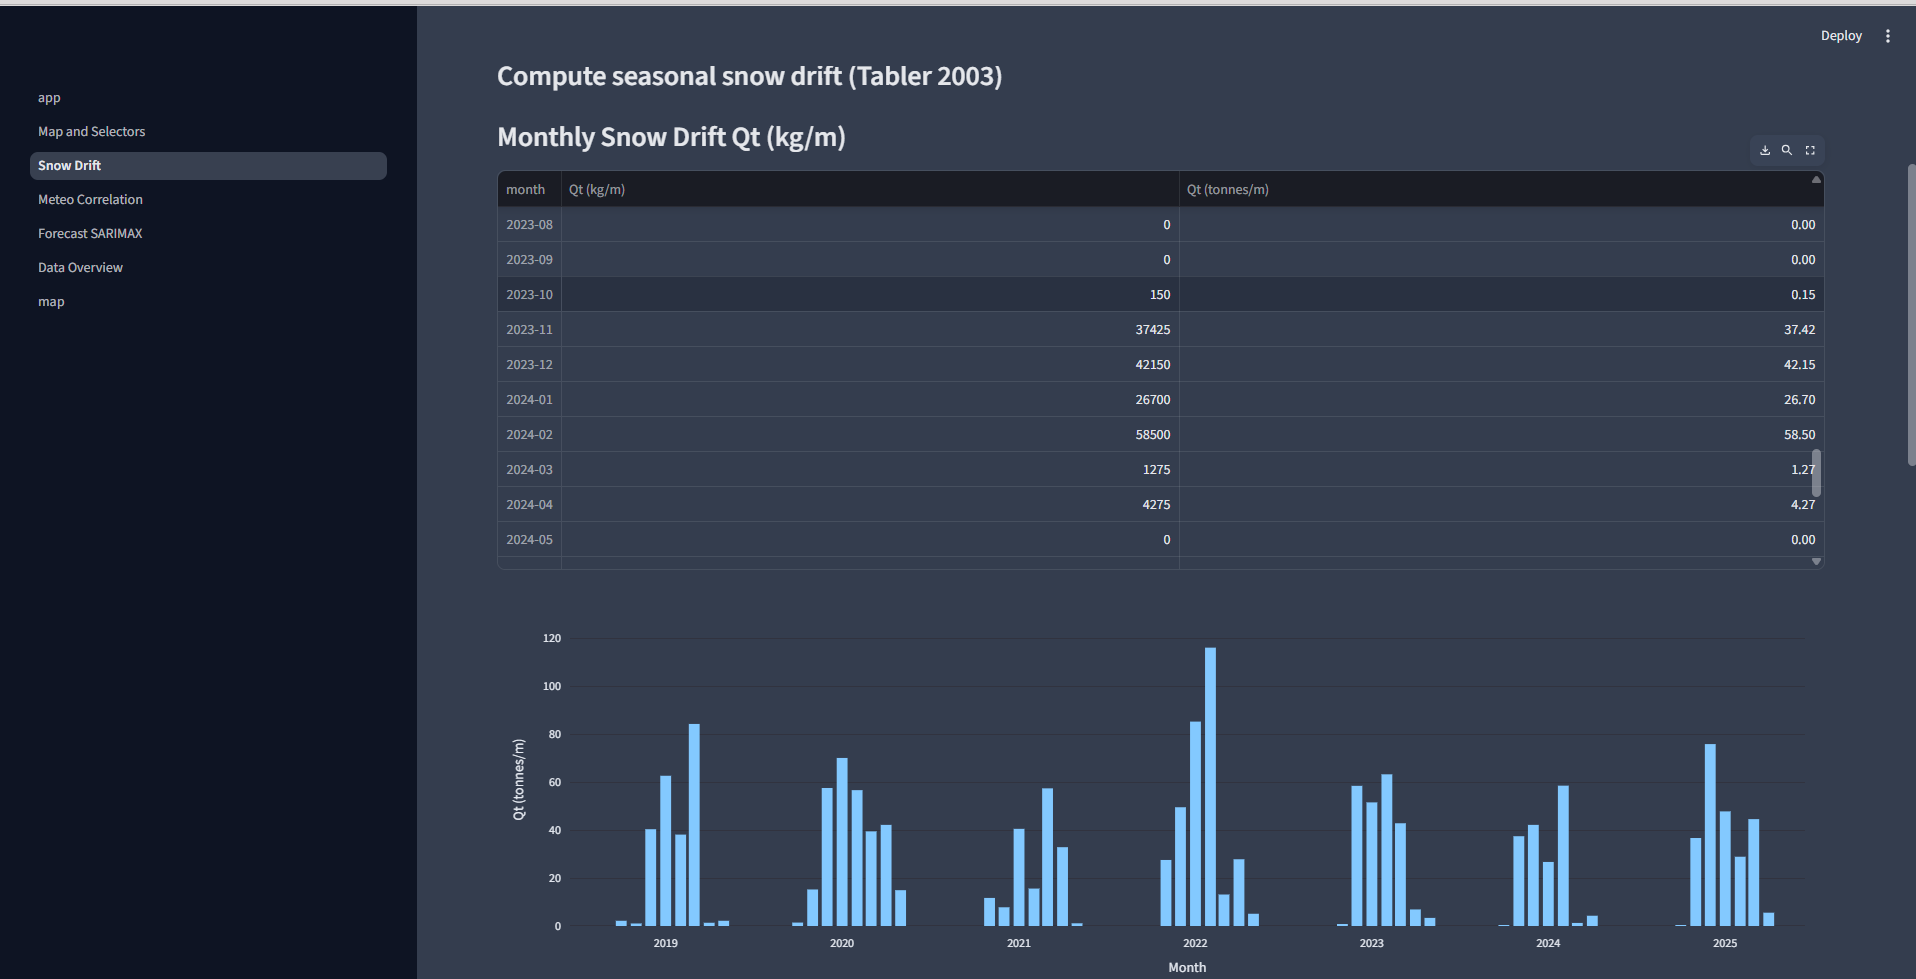
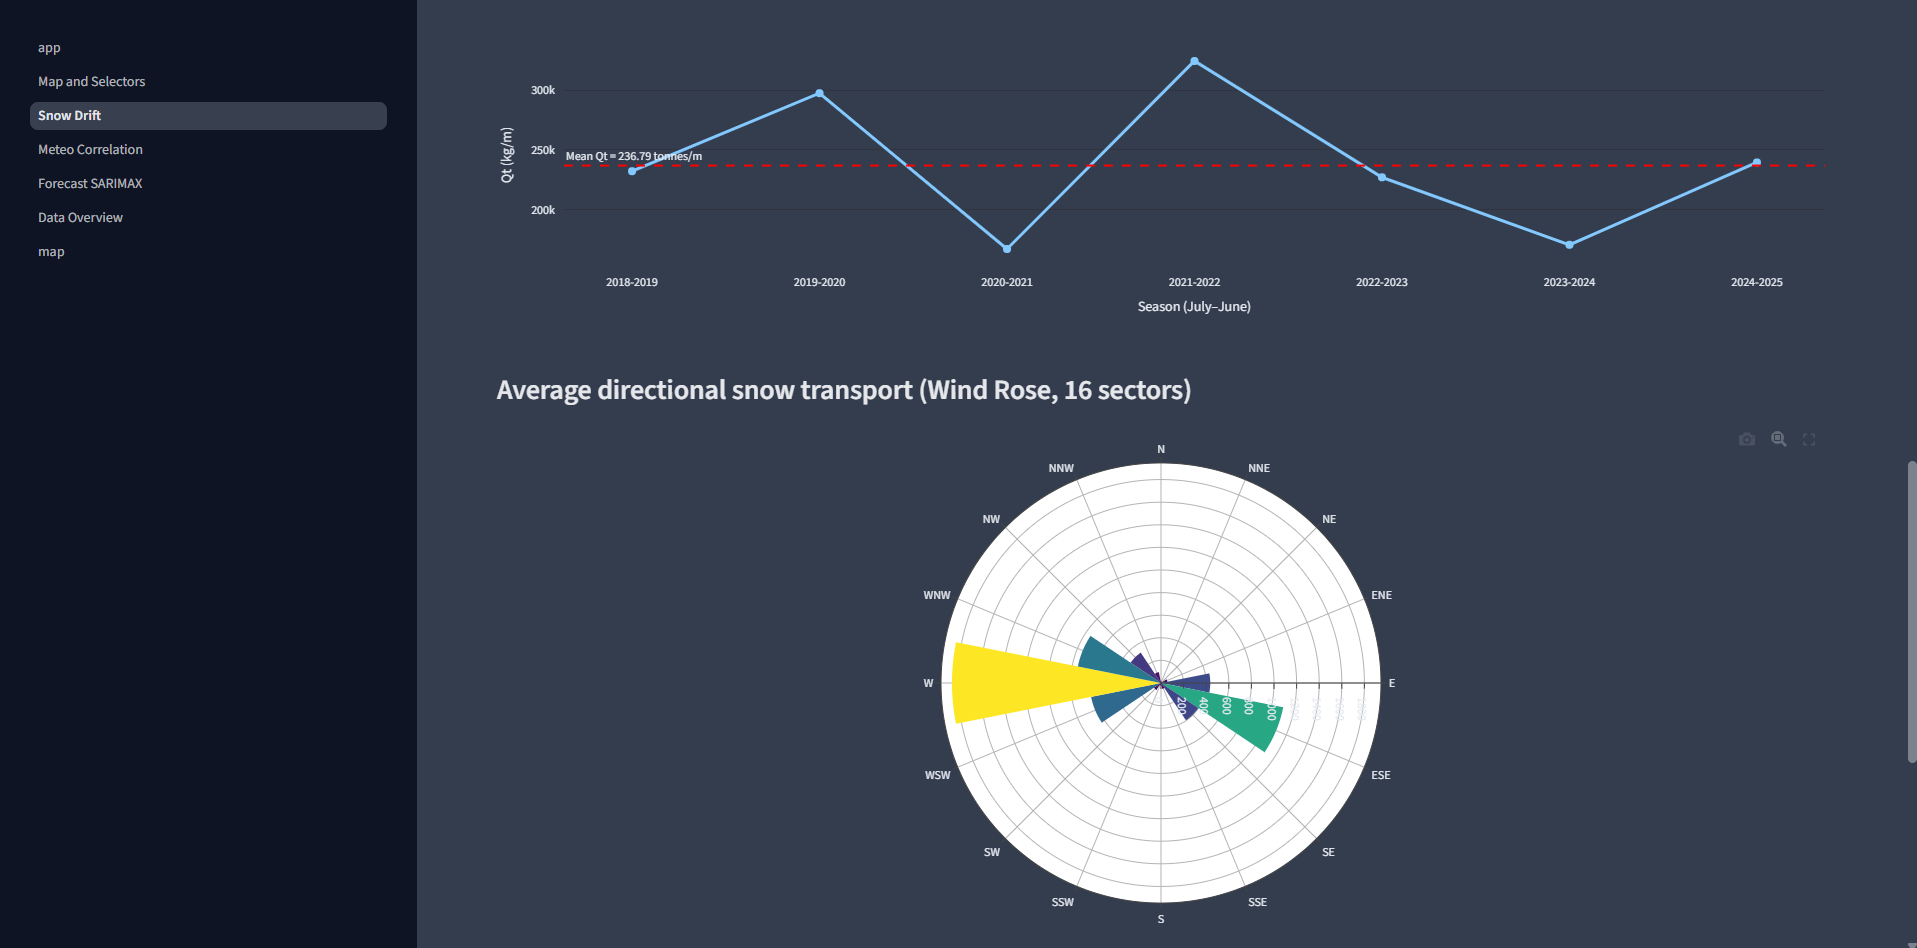
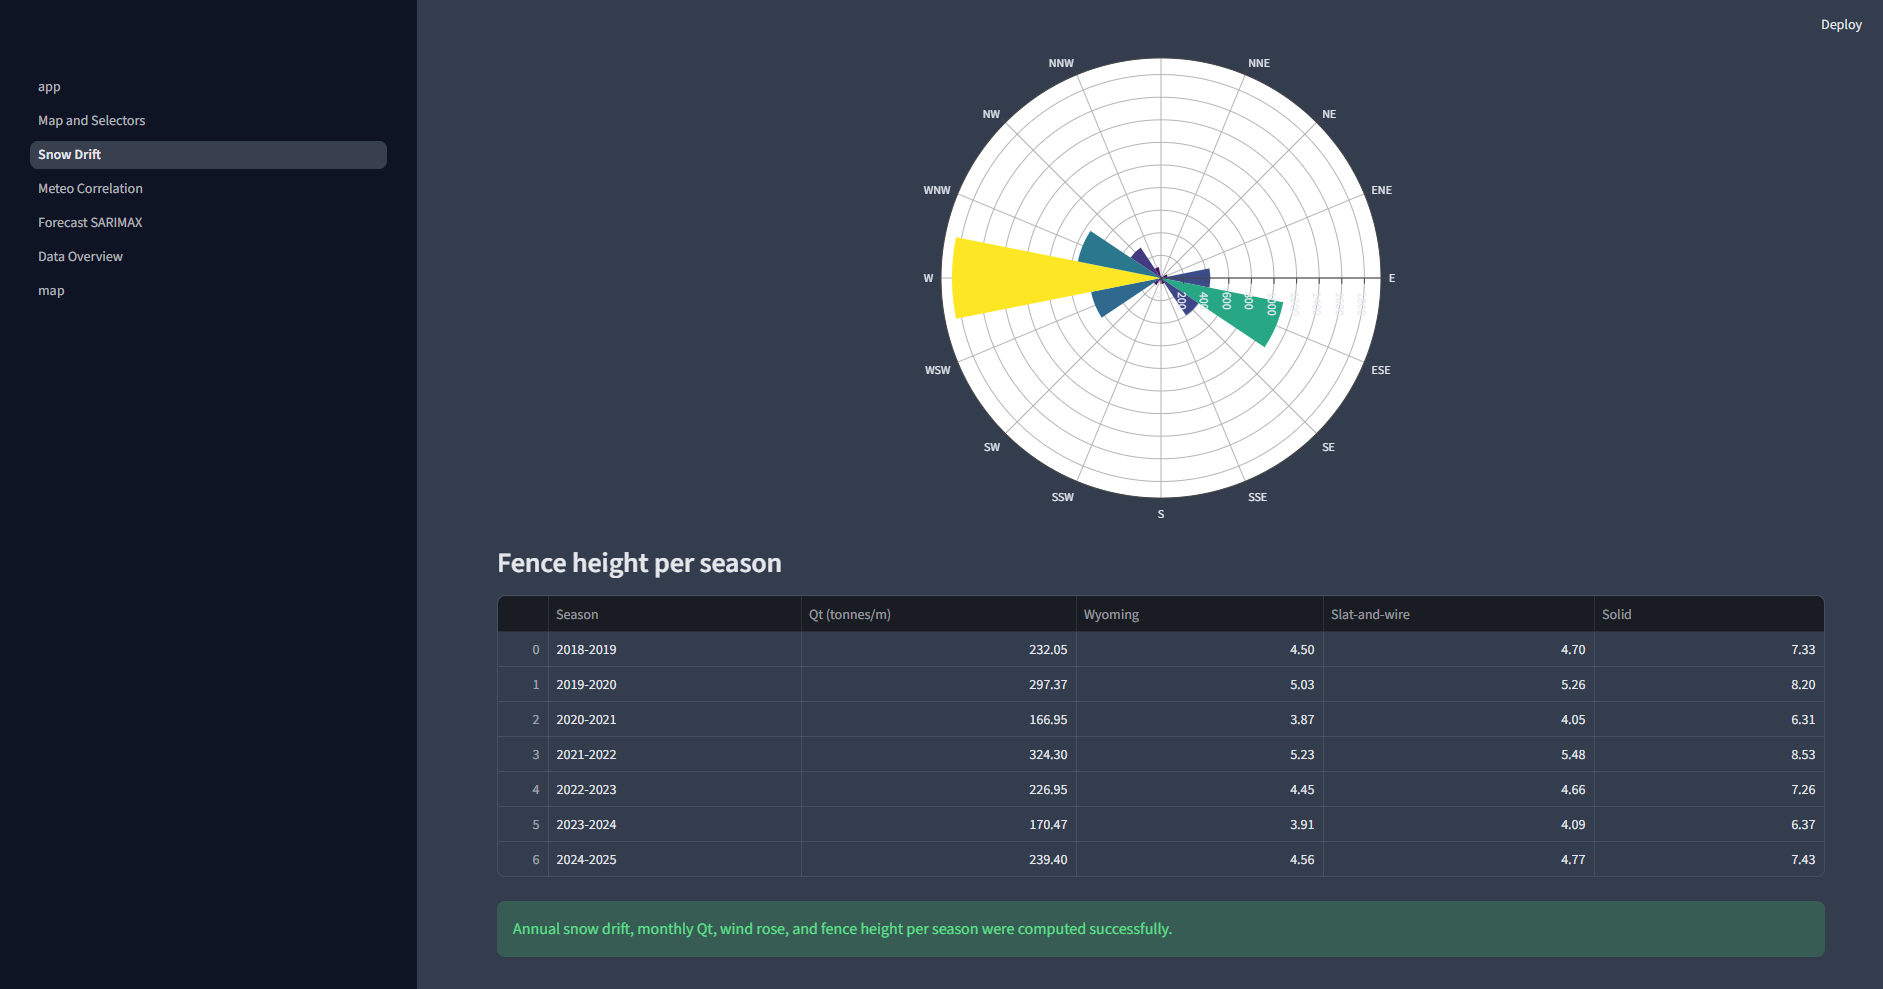

### Meteo–Energy Correlation 

The Meteo–Energy Correlation page shows how weather variables and energy production or consumption change together over time. The page uses a sliding-window correlation, where the user can choose the window size, lag, price area, energy group, and weather variables. The time-series plots display the selected energy data together with the weather data (such as temperature, wind speed, or precipitation), and the green line shows the correlation for each moment in time. These visuals help reveal short-term and long-term relationships, for example small positive correlation with temperature, weak and noisy patterns with wind speed, and sometimes a clearer connection between precipitation and hydro production. A small table also shows the most recent correlation value for the selected settings.


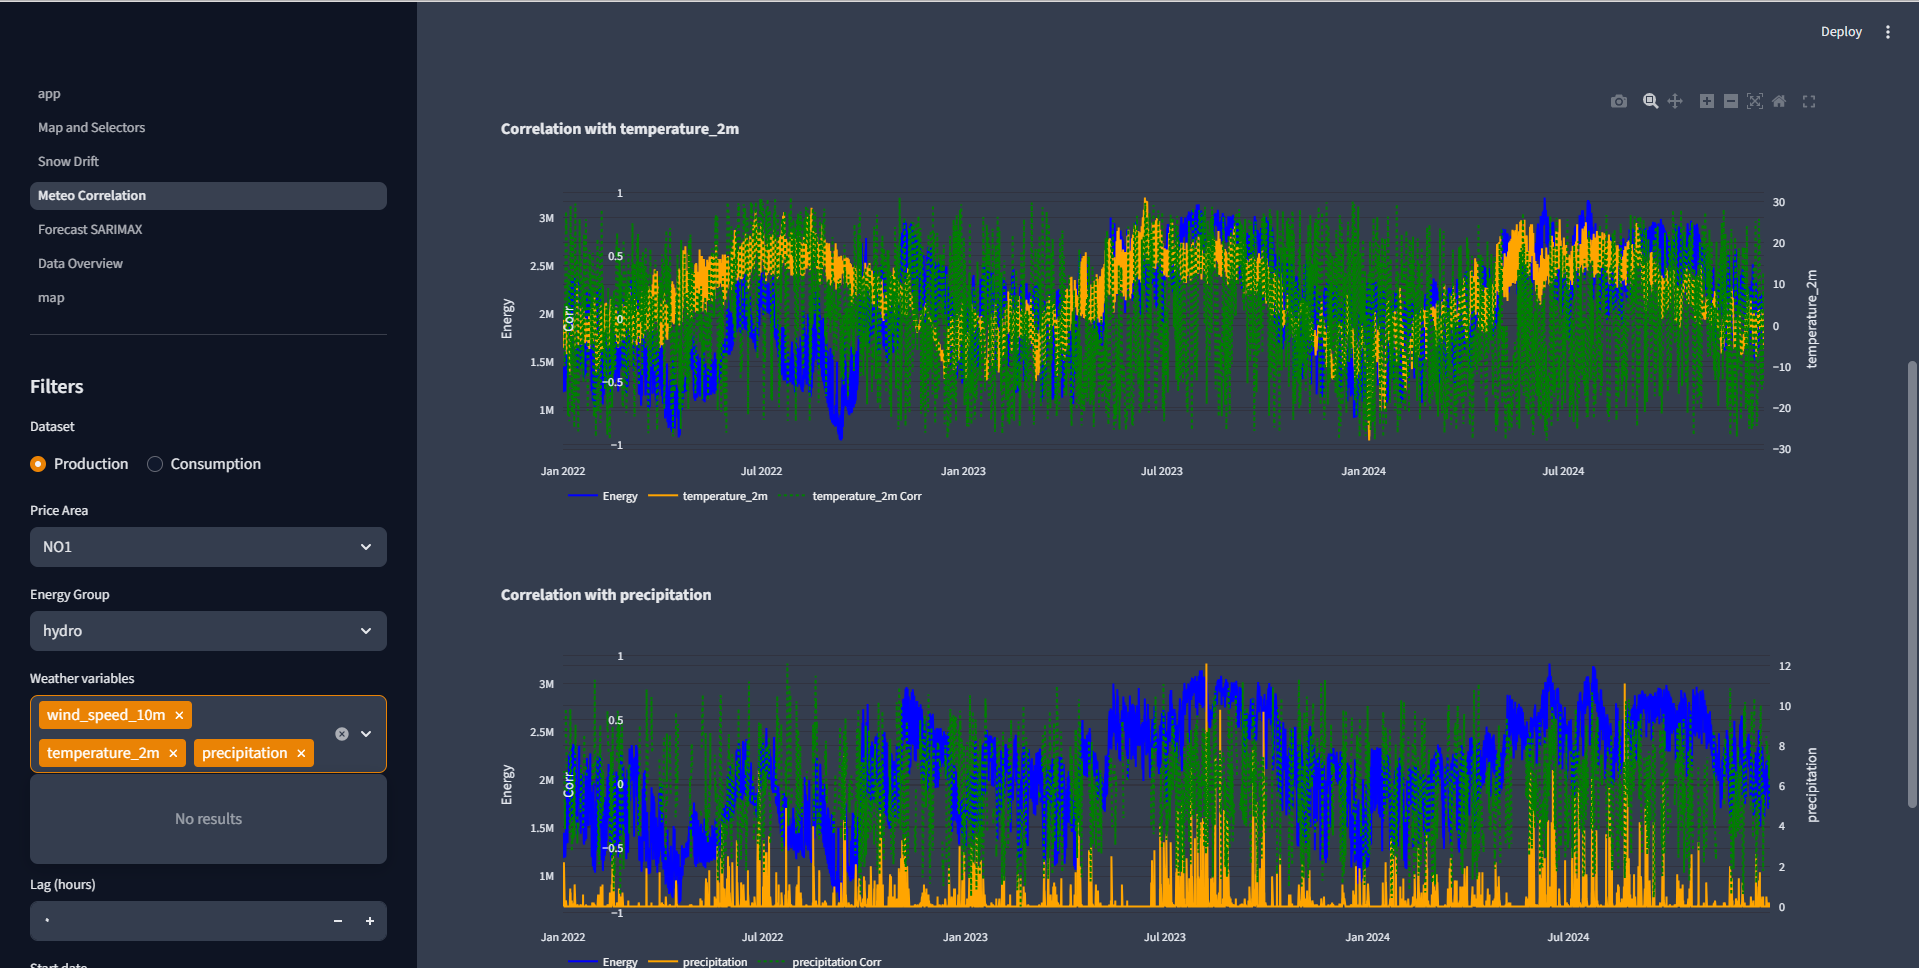](attachment:image.png)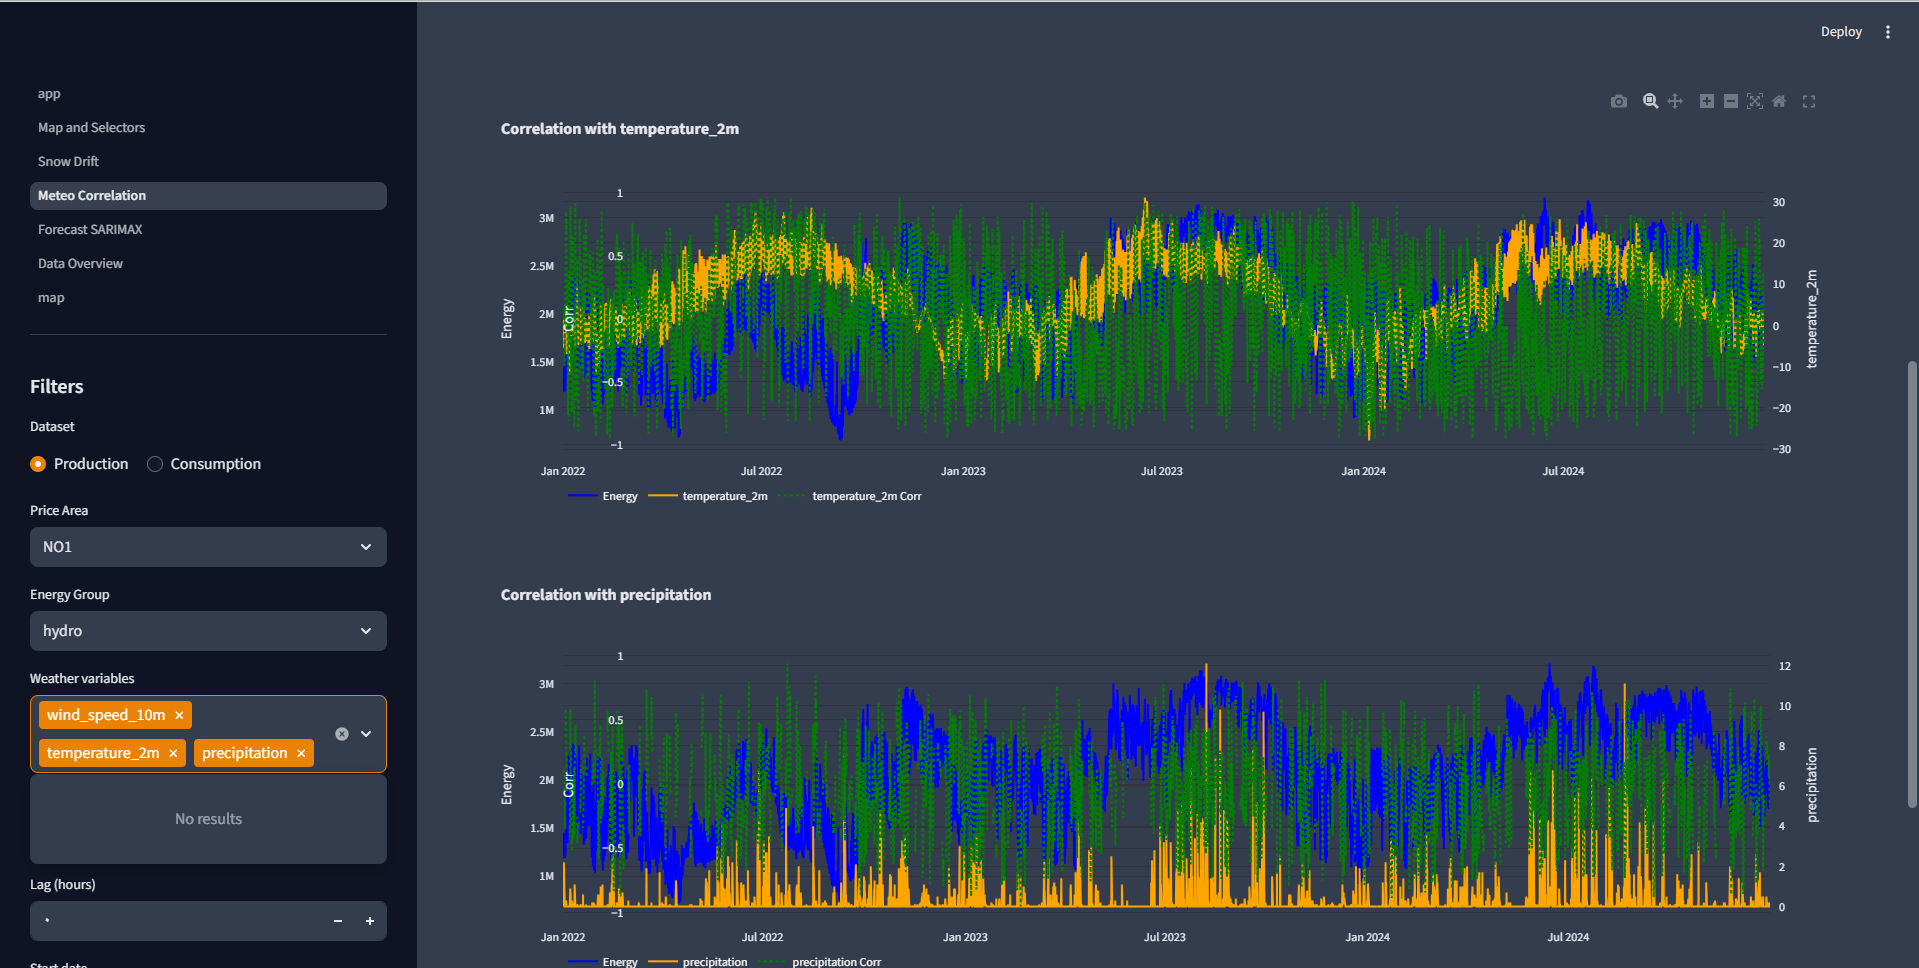

### Forecast SARIMAX Page

This screenshot shows the SARIMAX forecasting page, where the user selects the dataset type, price area, energy group, and training period.  
Once the model is trained, the app displays AIC/BIC values and plots both the historical data and the future forecast with a 95% confidence interval.  
The green message confirms that the forecast was completed successfully.


![Skjermbilde 2025-11-27 184841.png](<attachment:Skjermbilde 2025-11-27 184841.png>)
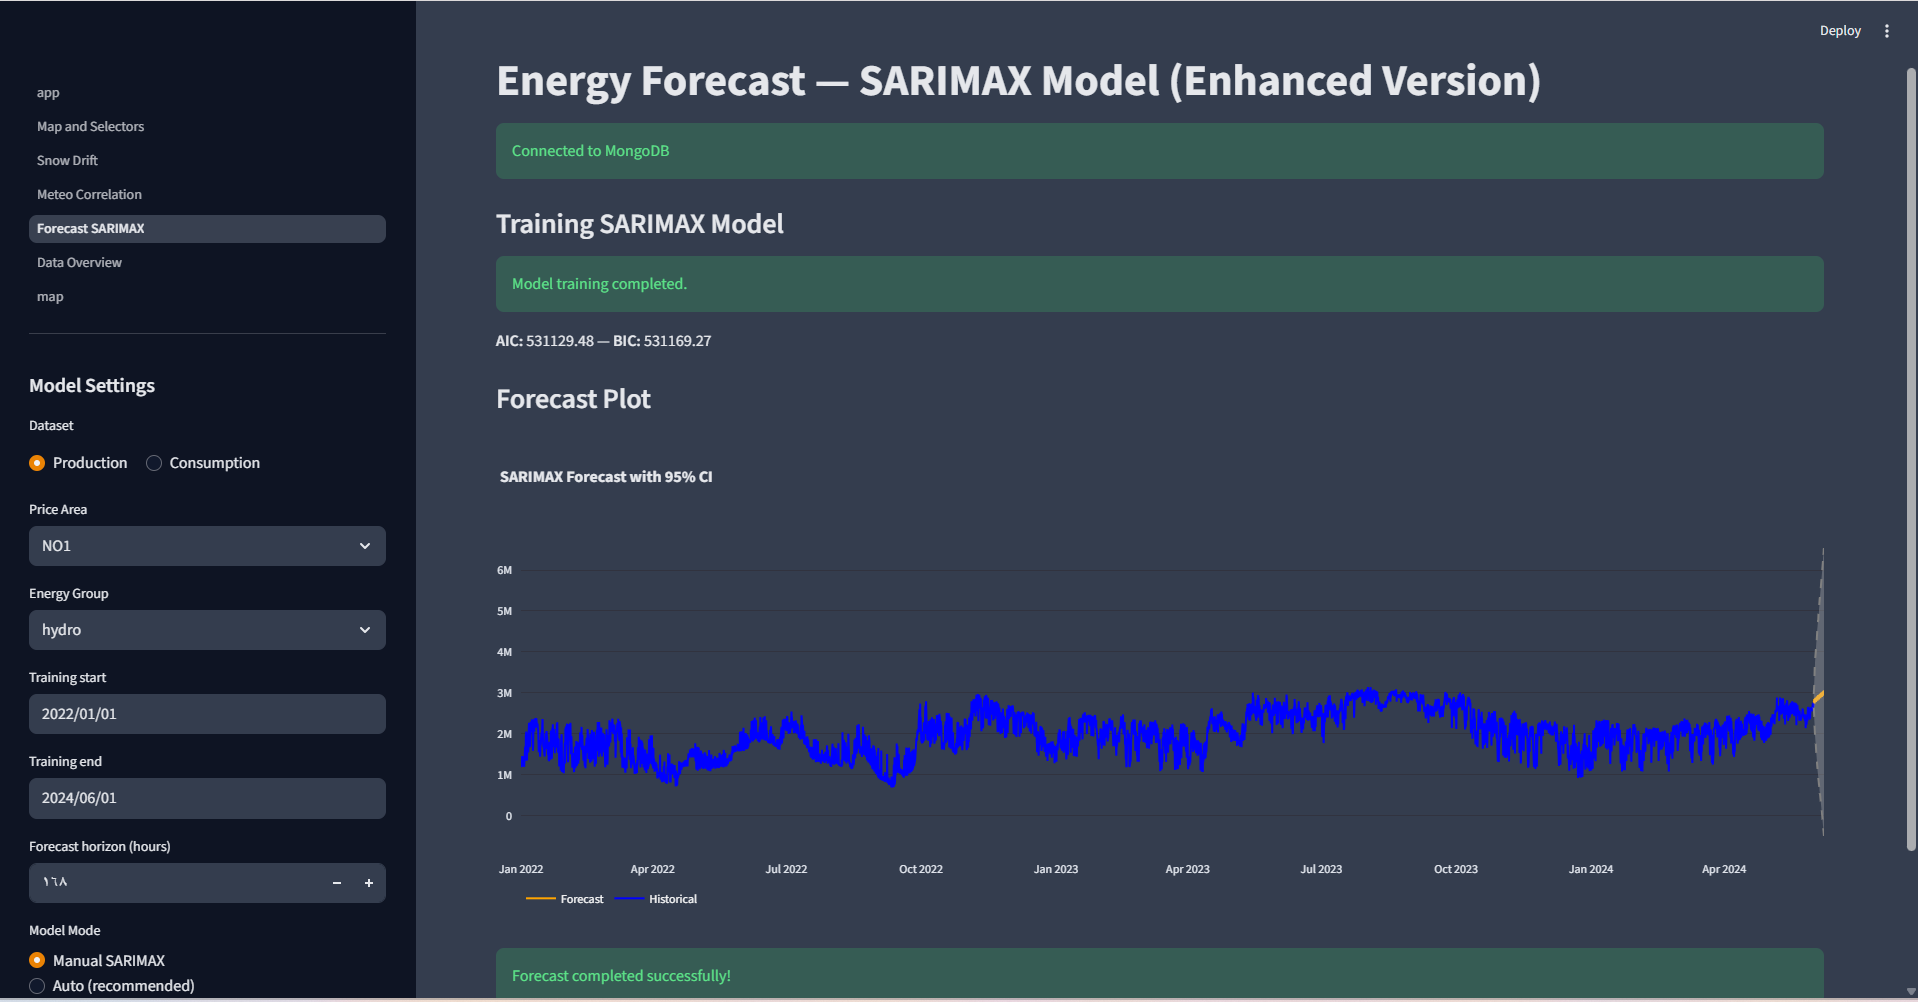

### Data Overview 

The Data Overview page gives a simple way to explore the energy data stored in MongoDB. The user can choose the dataset type, price area, energy group, date range, and number of rows to load. The page then shows basic summary statistics such as the number of rows, the date span, and the maximum, minimum, mean, and standard deviation of the selected data. A time-series plot displays how the energy values change over time, making it easy to see trends or daily patterns. A full data table is also provided so the user can inspect the raw values directly, and the data can be downloaded as CSV or JSON for further analysis.


![Skjermbilde 2025-11-27 180133.png](<attachment:Skjermbilde 2025-11-27 180133.png>) ![Skjermbilde 2025-11-27 180236.png](<attachment:Skjermbilde 2025-11-27 180236.png>)
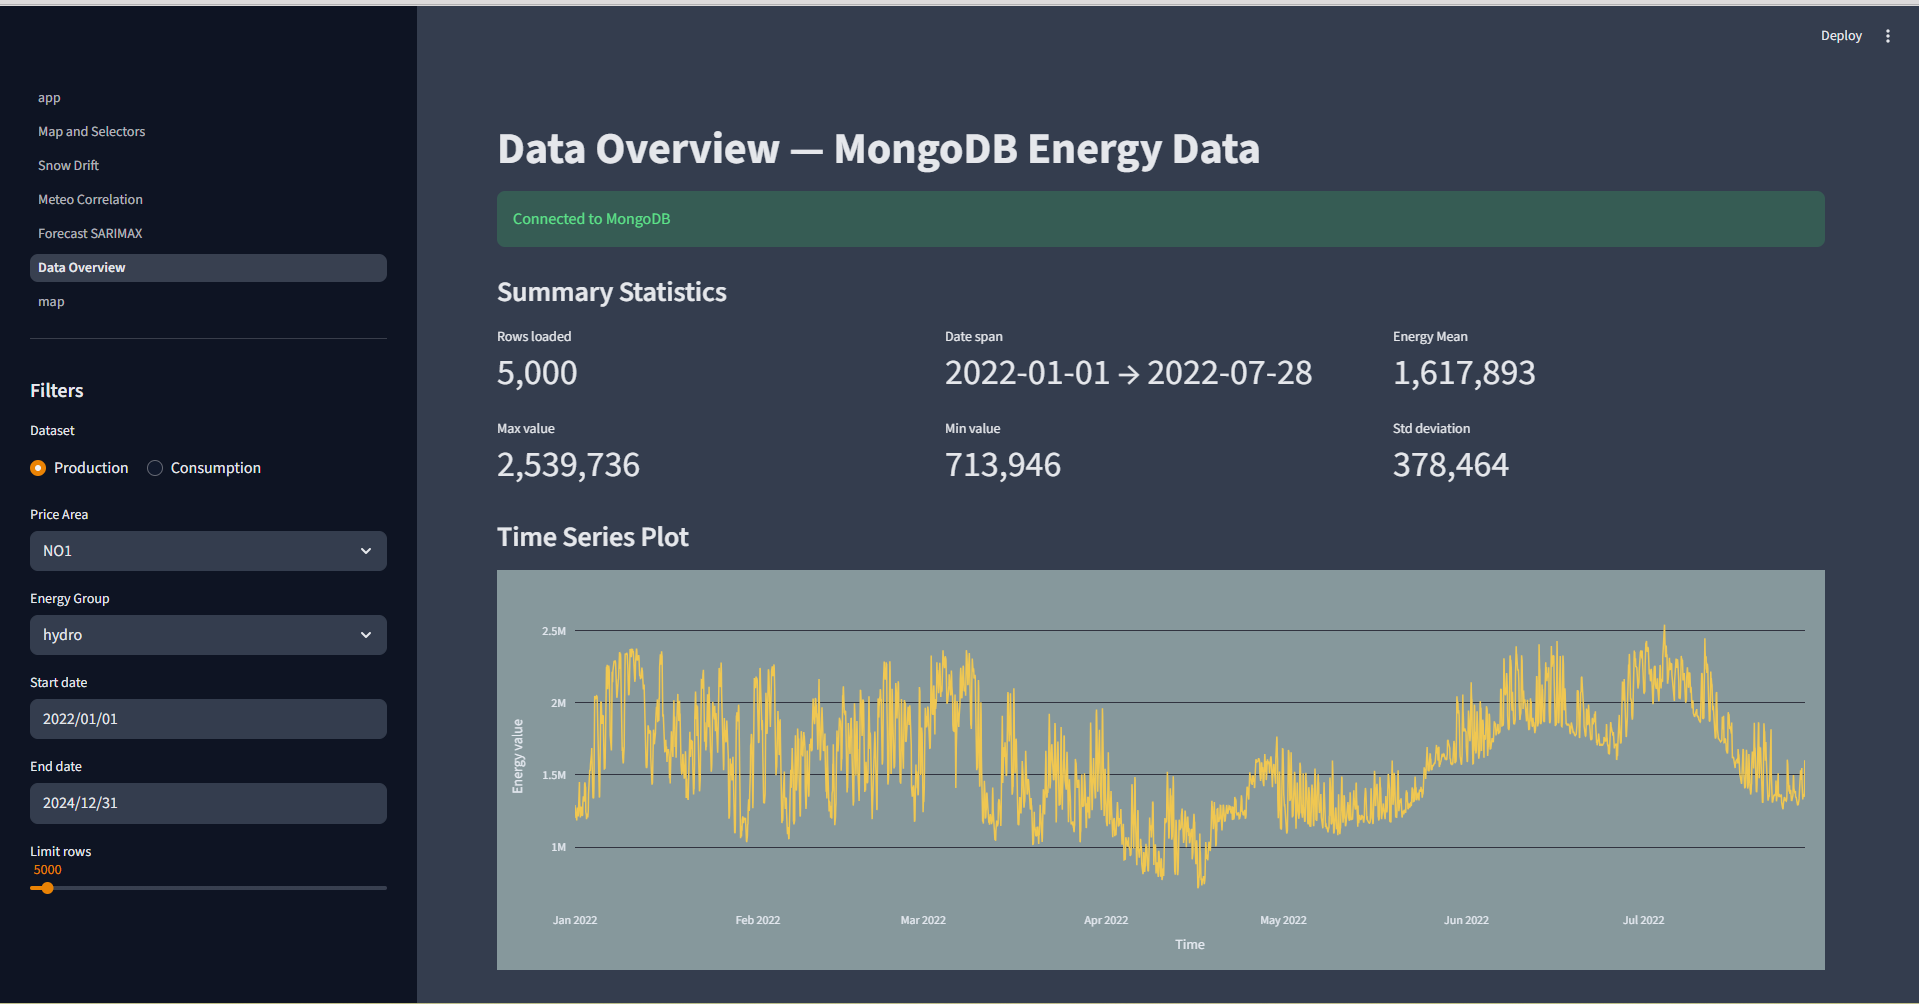
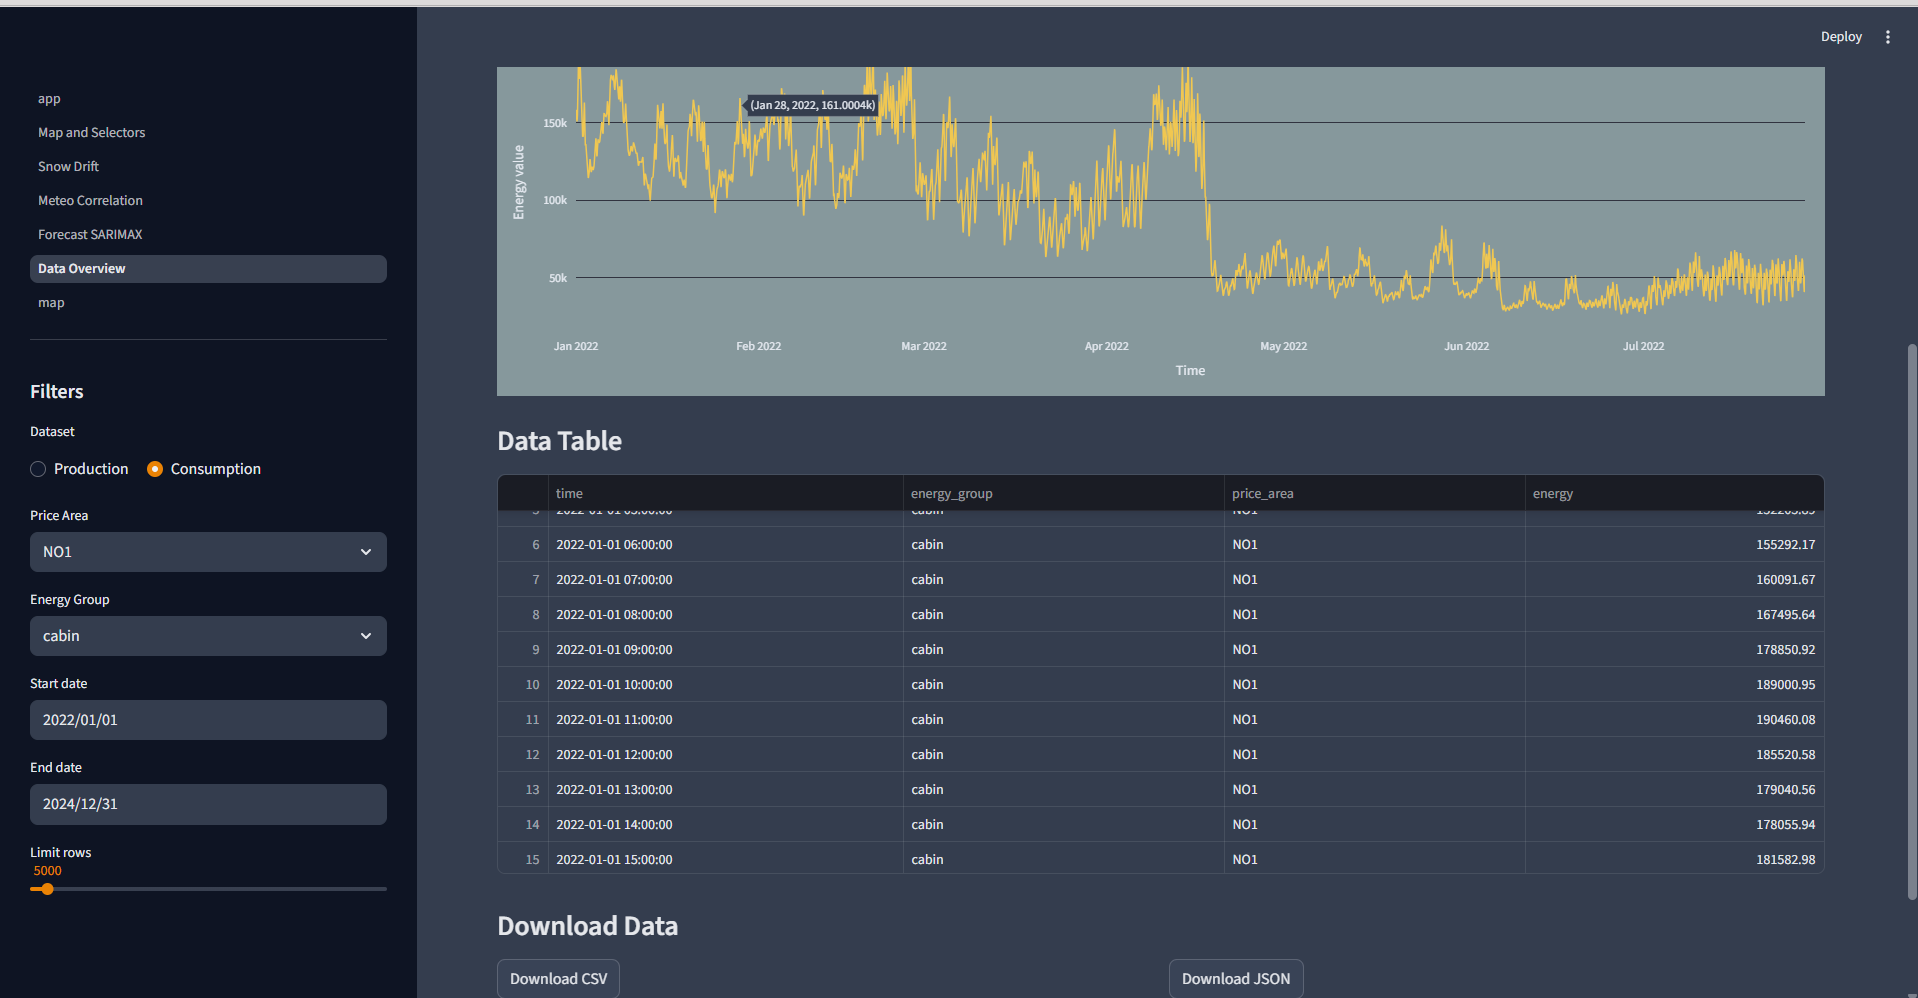